## Developing medical image analysis tools in Python with Scikit-image Workshop
### PyData Cambridge 14/11/2019
#### Author: Frank Longford

This notebook will guide users through a tutorial that will explore the scikit-image library to construct a pipeline for medical image analysis.

First we import all necessary packages, including NumPy and Matplotlib, and a couple of useful plotting functions from our local `plotting` library.

In [2]:
import numpy as np

import matplotlib.pyplot as plt

from plotting import plot_image, plot_image_and_hist

%matplotlib inline

## Importing an Image

If importing an image from file, use the `skimage.io.imread` function, which has pretty versitile file format handling (uses `pil` / `matplotlib` / `tiffile` loaders). If importing an image which is not in hexadecimal format (high colour resolution), then it is probably preferred to load it in as a NumPy array.

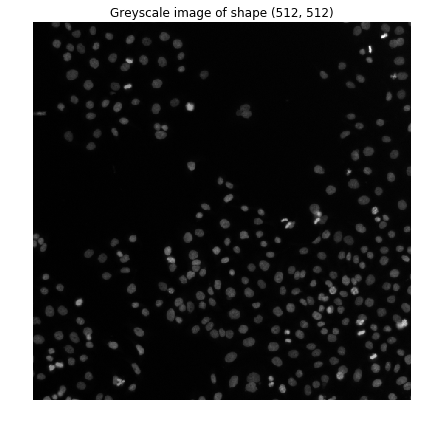

In [3]:
from skimage.io import imread

cell_image = imread("cell_example.tif")

plot_image(cell_image)

We shall use the `skimage.data.immunohistochemistry` example resource for this tutorial, which is supplied along with other demo images in the `skimage.data` module.

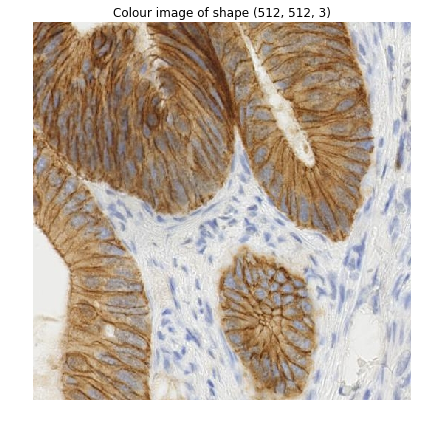

In [4]:
from skimage.data import immunohistochemistry

cell_image = immunohistochemistry()

plot_image(cell_image)

Here we see a colour image of a microscpe slide demonstrating immunohistochemical (IHC) stained cells. Before looking at this image we can already tell that it is in RGB format due to the shape (512, 512, 3). We are able to convert between RGB and greyscale formats using the `skimage.color.rgb2gray` conversion tool.

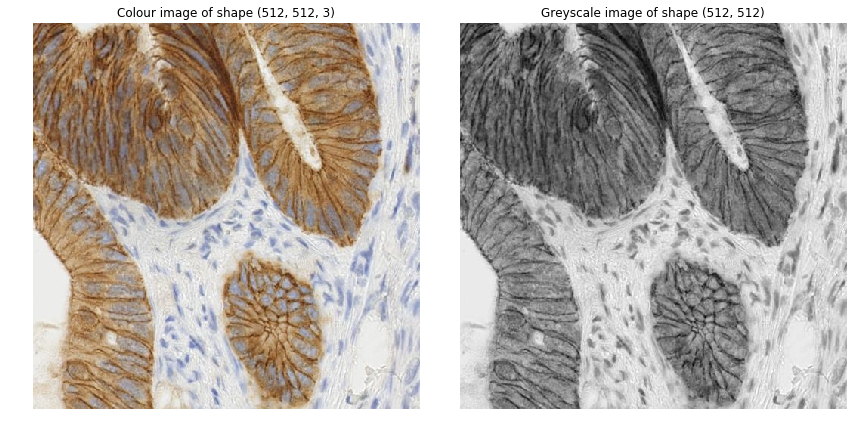

In [5]:
from skimage.color import rgb2gray

grayscale = rgb2gray(cell_image)

plot_image([cell_image, grayscale])

## Pre-processing

We can apply some operations to both RGB and greyscale versions of our image. These typically include

1) Filtering

2) Equalization

3) Restoration

Throughout this section will shall refer to the greyscale image as $f(x, y)$.

### Filtering

Filtering is typically achived by performing a convolution of the entire image using another function $h(x, y)$.

$g(x, y) = h(x, y) * f(x, y) = \int\limits_{s=-\infty}^\infty\int\limits_{t=-\infty}^\infty h(s, t) f(x + s, y + t) \:ds\:dt$

One of the most common filters uses a Gaussian function to perform this convolution. In which case, we also need to provide a value for the standard deviation $\sigma$ of the distribution.

$h(x, y, \sigma) = \frac{1}{2\pi\sigma^2} \exp\left[-\frac{x^2 + y^2}{2\sigma^2}\right]$

Below we apply the `skimage.filters.gaussian` function to our RGB and grayscale images. The only extra information that we should supply to the function for an RGB image is to set the keyword argument `multichannel=True`, so that `gaussian` interprets the format of the NumPy array accordingly.

/Users/flongford/.edm/envs/testing/lib/python3.6/site-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


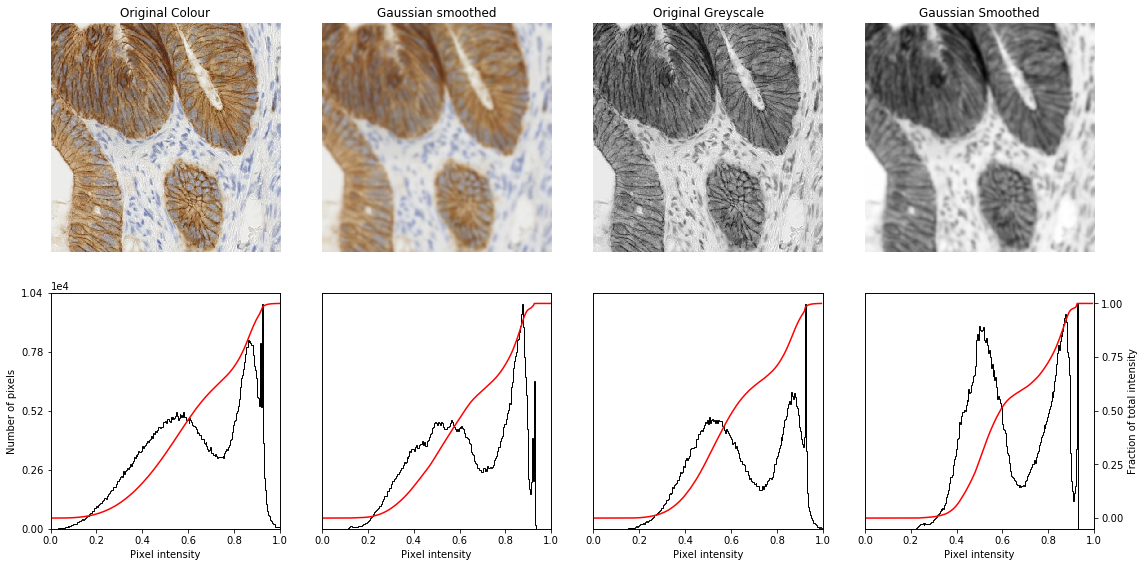

In [6]:
from skimage.filters import gaussian

smooth_rgb = gaussian(cell_image, sigma=3, multichannel=True)
smooth_grayscale = gaussian(grayscale, sigma=3)

plot_image_and_hist([cell_image, smooth_rgb, grayscale, smooth_grayscale],
                    ['Original Colour', 'Gaussian smoothed', 'Original Greyscale', 'Gaussian Smoothed'])

#### Kernel Filtering

Kernel filtering, or smoothing can be performed by performing a convolution over a region around each pixel with an applied matrix (or kernel) $\omega$ that defines the weight contributions of each pixel in the region.

$g(x, y) = \omega * f(x, y) = \sum\limits_{s=-a}^a\sum\limits_{t=-b}^b \omega(s, t) f(x - s, y - t)$

For example, calculating the mean value for a 3 x 3 region around each pixel is the equivalent of applying a mean filter using the kernel matrix:

$\omega = \frac{1}{9} \left(\begin{array}{lll} 1 & 1 & 1 \\ 1 & 1 & 1 \\ 1 & 1 & 1 \end{array}\right)$

For RGB images, the convolution is performed in each channel independently. 

In scikit-image, most kernel filters are located in the `skimage.filters.rank` module, whilst binary objects that define the shape of the kernels themselves (termed `selem`) are contained in the `skimage.morphology` module. In the example above, the selem would contain a 3 x 3 square matrix where each value is set to 1. The filter function (in this case, then mean) is then performed on top of this selem, which leads to the form of $\omega$ provided. If we wanted to use a different mean kernel that only included pixels within a certain radian integer distance (shown below), we can use the `disk` selem instead, resulting in the following equivalent expression for $\omega$:

$\omega = \frac{1}{5} \left(\begin{array}{lll} 0 & 1 & 0 \\ 1 & 1 & 1 \\ 0 & 1 & 0 \end{array}\right)$ 

In reality, a selem is just a binary NumPy array - additional selems found in the `skimage.morphology` module include `rectangle` and `star`, but you can also contribute any NumPy Array.

In [7]:
from skimage.morphology import square, disk, rectangle

square_selem = square(3)
disk_selem = disk(2)
rectangle_selem = rectangle(4, 3)

print("{} \n {} {} \n".format(square_selem, type(square_selem), square_selem.dtype))
print("{} \n {} {} \n".format(disk_selem, type(disk_selem), disk_selem.dtype))
print("{} \n {} {} \n".format(rectangle_selem, type(rectangle_selem), rectangle_selem.dtype))

[[1 1 1]
 [1 1 1]
 [1 1 1]] 
 <class 'numpy.ndarray'> uint8 

[[0 0 1 0 0]
 [0 1 1 1 0]
 [1 1 1 1 1]
 [0 1 1 1 0]
 [0 0 1 0 0]] 
 <class 'numpy.ndarray'> uint8 

[[1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]] 
 <class 'numpy.ndarray'> uint8 



An example of how different filters can affect the pixel intensity distribution of our image is given below. Here we apply the `skimage.filters.rank.mean`, `skimage.filters.rank.median` and `skimage.filters.rank.mean.bilateral` filters, using the same selem `disk(5)`.

The Bilateral Mean filter is particulary useful, as it is able to retain the contrast between different areas of detail whilst also reducing the overall noise. This is achieved by including the intensity as an extra component in $\omega$ that takes into account the difference in pixel intensities. 

/Users/flongford/.edm/envs/testing/lib/python3.6/site-packages/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/Users/flongford/.edm/envs/testing/lib/python3.6/site-packages/skimage/filters/rank/bilateral.py:41: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)


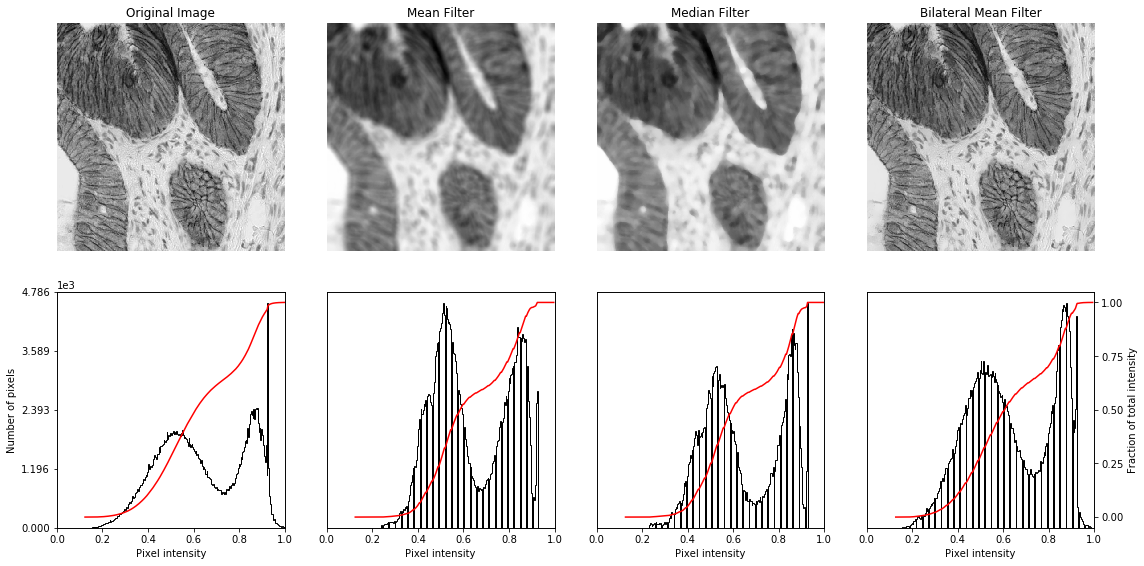

In [8]:
from skimage.filters.rank import mean, median, mean_bilateral

selem = disk(8)

mean_filter = mean(grayscale, selem)
median_filter = median(grayscale, selem)
bilateral_mean_filter = mean_bilateral(grayscale, selem)

plot_image_and_hist([grayscale, mean_filter,
                     median_filter, bilateral_mean_filter],
                    ['Original Image', 'Mean Filter',
                     'Median Filter', 'Bilateral Mean Filter'])

### Equalisation

Often an image may suffer from under or over exposure, leading to an imbalance in contrast. Shot-noise may also lead to certain pixels having an artifically high or low intensity, which will affect any derivative-derived properties. Equalization of an image's pixel distribution can provide a way to remove such artefacts.

Below we rescale the intensities with the `rescale_intensity` function to lie with the range of 2-98% of thier original values. This will remove the extrema values, resulting in a more even distribution at the loss of some local details.

A slightly more intelligent equalisation method is to rescale the intensities until they yeild a linear culumative distribution function, which can be performed by calling `equalize_hist`. Again, this is performed on the entire image and so some local detail can be lost. Alternatively, the adaptive equalization routine `equalize_adapthist` performs the same procedure, yet over a specified local kernel. Therefore the global intensity distribution will not be linear and some local features will be retained. This is particulary useful if we have an exposure imbalance in an image, leading to some areas being lighter than others.


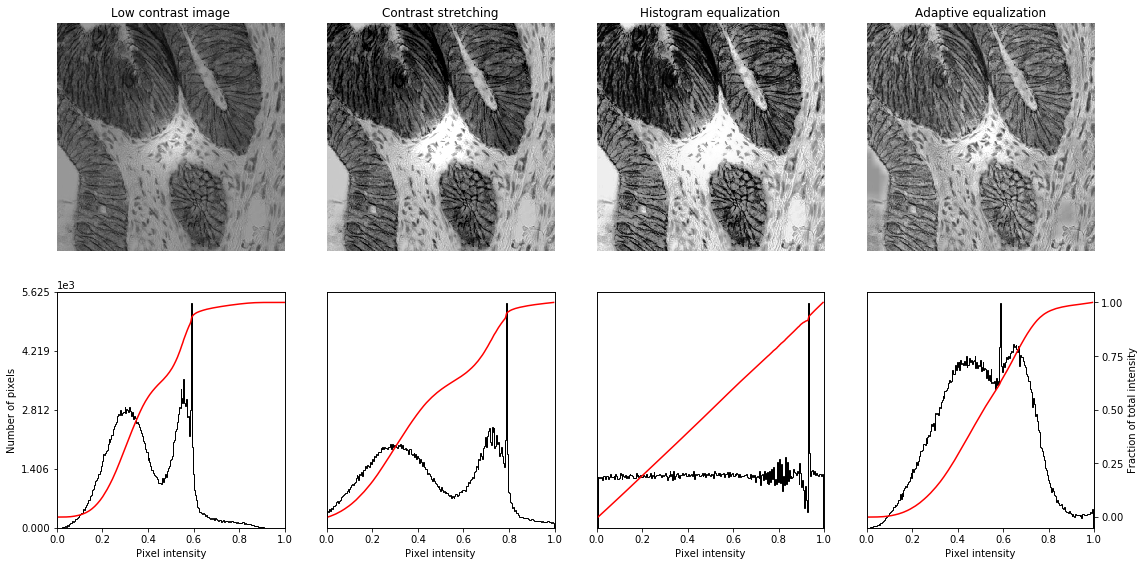

In [9]:
from skimage.exposure import rescale_intensity, equalize_adapthist, equalize_hist
from scipy import signal

def gaussian_kernel(kernlen=21, std=3):
    """Returns a 2D Gaussian kernel array."""
    
    gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
    
    gkern2d = np.outer(gkern1d, gkern1d)
    
    return gkern2d


imbalanced = grayscale * (1 + 0.5 * gaussian_kernel(grayscale.shape[0], std=50))
imbalanced = (imbalanced - imbalanced.min()) / (imbalanced.max() - imbalanced.min())

# Contrast stretching
p2, p98 = np.percentile(imbalanced, (2, 98))
img_rescale = rescale_intensity(imbalanced, in_range=(p2, p98))

# Equalization
img_eq = equalize_hist(imbalanced)

# Adaptive Equalization
img_adapteq = equalize_adapthist(imbalanced, kernel_size=(16, 16))

plot_image_and_hist([imbalanced, img_rescale, img_eq, img_adapteq],
                    ['Low contrast image', 'Contrast stretching',
                     'Histogram equalization', 'Adaptive equalization'])

### Restoration

One extra state-of-the-art filtering method in scikit-image is the non-local means algorithm, which attempts to restore features of an image that may have been lost due to noise.

Again, is works in a similar way to the bilateral mean, whereby the local mean of each pixel is first calculated for a given kernel as $\mathbf{B}(x, y)$. A Gaussian convolution is then performed using the difference in pixel intensities of $\mathbf{B}(x, y)$ to calculate the weights,

$h(x, y, s, t) = \exp\left[-\frac{|\mathbf{B}(x + s, y + t)- \mathbf{B}(x, y)|^2}{\sigma^2}\right]$

so that the full convolution is given by,

$g(x, y) = \frac{1}{C(x, y)}\int\limits_{s=-\infty}^\infty\int\limits_{t=-\infty}^\infty h(x, y, s, t) f(x + s, y + t) \:ds\:dt$

with a normalisaing factor

$C(x, y) = \int\limits_{s=-\infty}^\infty\int\limits_{t=-\infty}^\infty h(x, y, s, t) \:ds\:dt$

In reality, the integrals shown above are performed as partial integrals over local region around each pixel.

The code below performs the non-local means algorithm using a square kernel of size `patch_size` for calculating $\mathbf{B}(x, y)$ and a Gaussaian standard deviation of `sigma`.

Actual noise std: 0.08  Estimated noise std = 0.07933390505610159


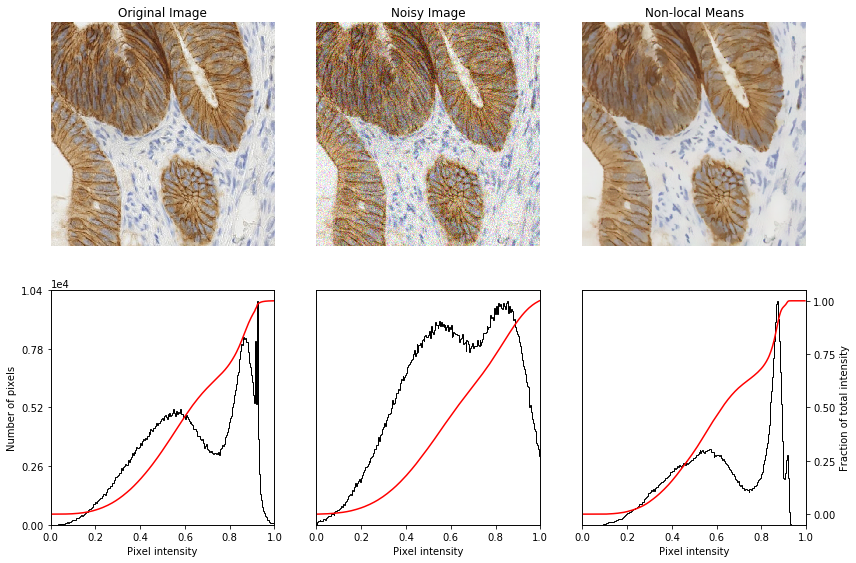

In [10]:
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.util import random_noise

sigma = 0.08
noisy_image = random_noise(cell_image, var=sigma**2)

sigma_est = estimate_sigma(noisy_image, multichannel=True)
sigma_est = np.mean(sigma_est)
print('Actual noise std: {}  Estimated noise std = {}'.format(sigma, sigma_est))

restored_image = denoise_nl_means(
    noisy_image, patch_size=5, h=0.6 * sigma_est, 
    sigma=sigma_est, fast_mode=True, multichannel=True)

plot_image_and_hist([cell_image, noisy_image,
                     restored_image],
                    ['Original Image', 'Noisy Image',
                     'Non-local Means'])

In general, pre-processing can be very useful and there are plenty of options readily available in scikit-image

## Analysis

Let's now explore some of the structural details of this greyscale image using the `skimage.feature.structure_tensor` and `skimage.feature.hessian_matrix` routines. Both use numerical estimates of the derivates of $f(x, y)$ to extract properties of the image, in the same way we might investigate propertes of a surface.

### Structure Tensor

Using our greyscale, single channel image, $f(x, y)$, we can examine the structure tensor to obtain information on the primary derivatives (the Jacobian $\mathbf{J}(x, y)$).

$\mathbf{J}(x, y) = \left[\frac{\partial f(x, y)}{\partial x}, \frac{\partial f(x, y)}{\partial y}\right]$

The structure tensor $\mathbf{K}(x, y)$ is defined as

$\begin{align} 
    \mathbf{K}(x, y) &= \mathbf{J}(x, y) \cdot \mathbf{J}(x, y)^{\mathbf{T}} \\
    &= \left[\begin{array}{cc} 
        \left(\frac{\partial f(x, y)}{\partial x^2}\right)^2 & \frac{\partial f(x, y)}{\partial y}\frac{\partial f(x, y)}{\partial x} \\
        \frac{\partial f(x, y)}{\partial x}\frac{\partial f(x, y)}{\partial y} & \left(\frac{\partial f(x, y)}{\partial y}\right)^2
    \end{array}\right]
\end{align}$

Therefore we can see that there are only 3 unique elements in this 2 x 2 tensor, $\mathbf{K}_{00}(x, y)$, $\mathbf{K}_{01}(x, y)$ and $\mathbf{K}_{11}(x, y)$

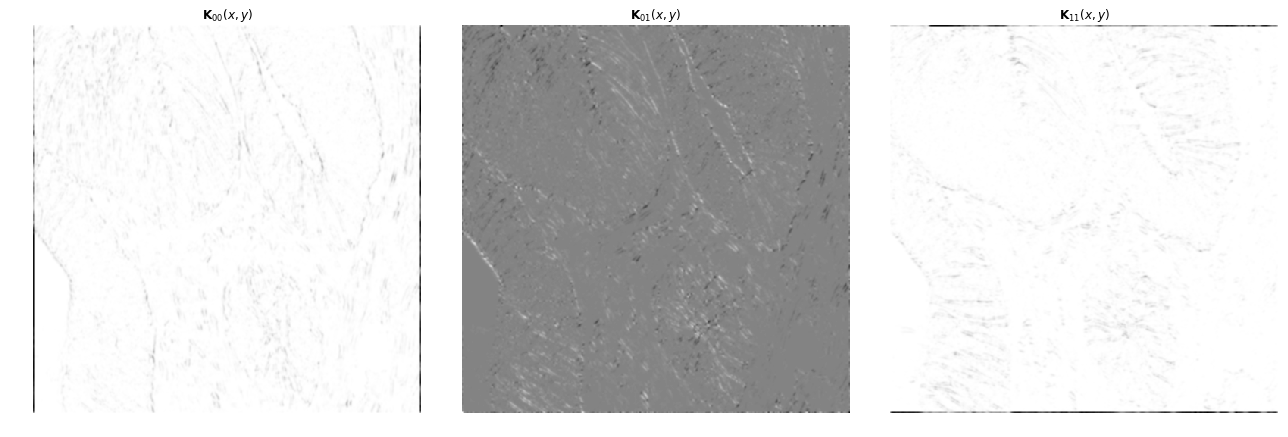

In [11]:
from skimage.feature import structure_tensor

structure = structure_tensor(grayscale)

titles = [r'$\mathbf{K}_{00}(x, y)$',
          r'$\mathbf{K}_{01}(x, y)$',
          r'$\mathbf{K}_{11}(x, y)$']

plot_image(structure, titles=titles, cmap=plt.cm.gray_r)

The eigenvalues $\lambda_{max}$, $\lambda_{min}$ and eigenvectors $e_{max}$, $e_{min}$of the structure tensor can be interpreted as summaraising the distribution of gradients centered on pixel $x, y$. The anisotropy (or coherence) in gradient directions can be interpreted from the difference in min and max eigenvalues

$n(x, y) = \left(\frac{\lambda_{max} - \lambda_{min}}{\lambda_{max} + \lambda_{min}}\right)^2$

with the overall direction is defined in terms of 

$\theta(x, y) = \frac{1}{2} \arctan\left(\frac{2\mathbf{K}_{xy}(x, y)}{\mathbf{K}_{yy}(x, y) - \mathbf{K}_{xx}(x, y)}\right)$

And the energy is defined in terms of the trace of the structure tensor

$\psi(x, y) = |{K}_{xx}(x, y)| + |{K}_{yy}(x, y)|$

/Users/flongford/.edm/envs/testing/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


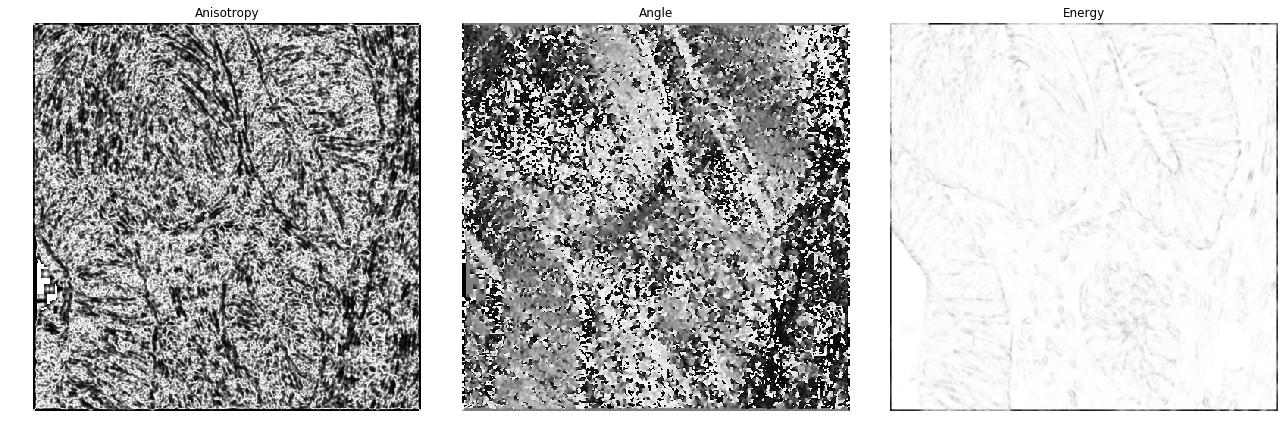

In [12]:
from skimage.feature import structure_tensor_eigvals

def structure_properties(structure):

    eig_val = structure_tensor_eigvals(*structure)
    eig_diff = (eig_val[0] - eig_val[1])
    eig_sum = eig_val[0] + eig_val[1]
    
    tensor = np.array([[structure[0], structure[1]],
                       [structure[1], structure[2]]])

    anisotropy = np.divide(eig_diff, eig_sum)**2
    angle = np.arctan2(2 * structure[1], (structure[2] - structure[0])) / np.pi * 180
    energy = np.trace(np.abs(tensor), axis1=0, axis2=1)

    return anisotropy, angle, energy


anisotropy, angle, energy = structure_properties(structure)

plot_image([anisotropy, angle, energy], titles=['Anisotropy', 'Angle', 'Energy'], cmap=plt.cm.gray_r)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


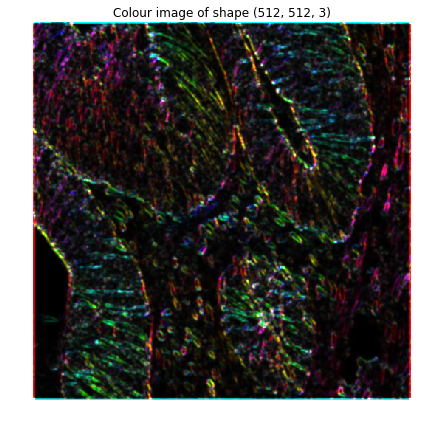

In [21]:
from skimage.color import hsv2rgb

hue = (angle + 180) / 360

hsv_image = np.stack([hue, anisotropy, energy], axis=-1)

plot_image(hsv2rgb(hsv_image))


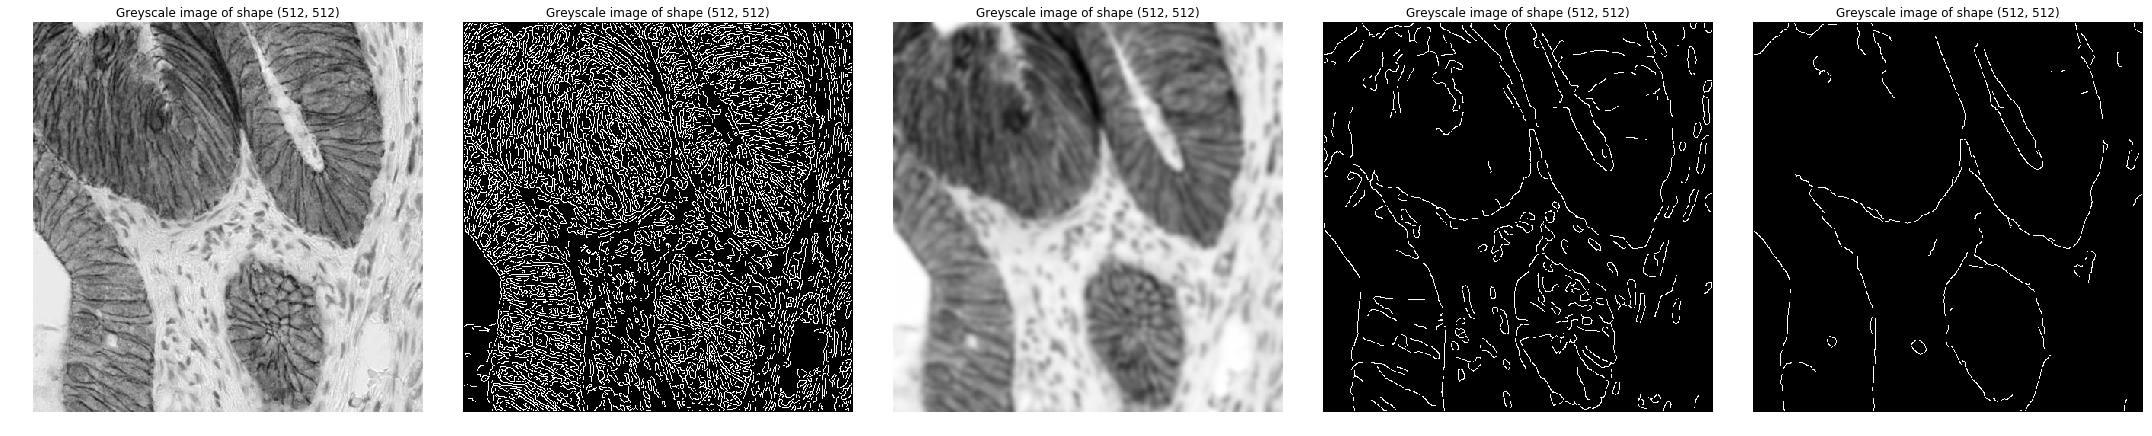

In [15]:
from skimage.feature import canny

plot_image([grayscale, canny(grayscale), gaussian(grayscale, sigma=3), canny(grayscale, sigma=3),
           canny(median(grayscale, disk(10)))])

In [ ]:
from skimage.morphology import binary_closing
from scipy import ndimage as ndi

edges = canny(grayscale, sigma=2)

filled = ndi.binary_fill_holes(edges)

plot_image(filled)

### Hessian Tensor
$\mathbf{H}(x, y) = \left[\begin{array}{cc} 
    \frac{\partial^2 f(x, y)}{\partial x^2} & \frac{\partial^2 f(x, y)}{\partial y\partial x} \\
    \frac{\partial^2 f(x, y)}{\partial x\partial y} & \frac{\partial^2 f(x, y)}{\partial y^2}
\end{array}\right]$

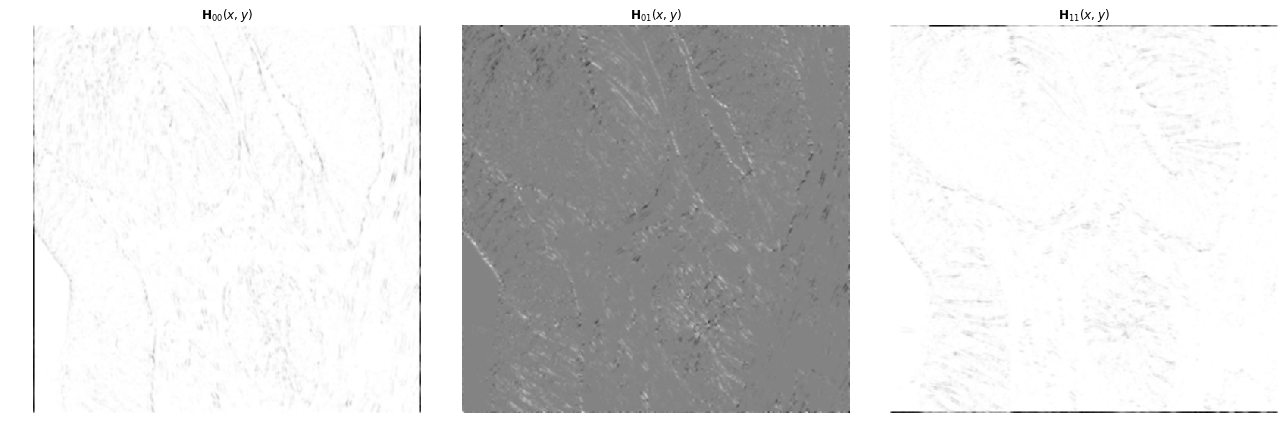

In [16]:
from skimage.feature import hessian_matrix

hessian = hessian_matrix(grayscale)

titles = [r'$\mathbf{H}_{00}(x, y)$',
          r'$\mathbf{H}_{01}(x, y)$',
          r'$\mathbf{H}_{11}(x, y)$']

plot_image(structure, titles=titles, cmap=plt.cm.gray_r)

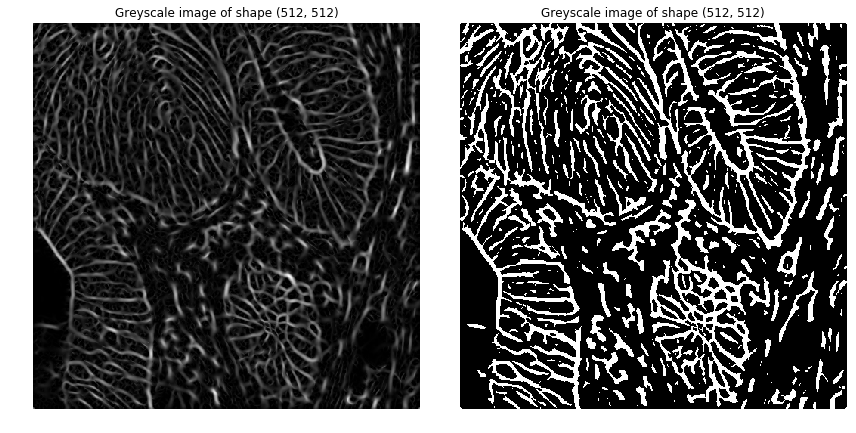

In [17]:
from skimage.filters import sato, threshold_isodata

tubeness = sato(grayscale, sigmas=range(1, 4))

plot_image([tubeness, tubeness > threshold_isodata(tubeness)])

In [ ]:
from skimage.morphology import watershed

filled = ndi.binary_fill_holes(tubeness)

plot_image(filled)

/Users/flongford/.edm/envs/testing/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  if sys.path[0] == '':


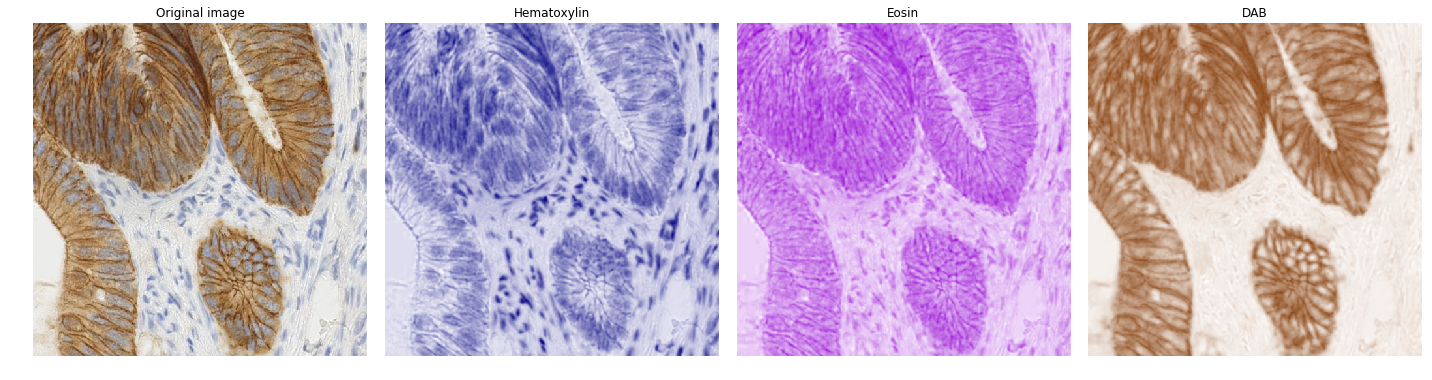

In [18]:
from skimage.color import rgb2hed
from matplotlib.colors import LinearSegmentedColormap


# Create an artificial color close to the original one
cmap_hema = LinearSegmentedColormap.from_list('mycmap', ['white', 'navy'])
cmap_dab = LinearSegmentedColormap.from_list('mycmap', ['white',
                                             'saddlebrown'])
cmap_eosin = LinearSegmentedColormap.from_list('mycmap', ['darkviolet',
                                               'white'])

smoothed = gaussian(cell_image)

hed_image = rgb2hed(smoothed)

fig, axes = plt.subplots(1, 4, figsize=(20, 6), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(cell_image)
ax[0].set_title("Original image")

ax[1].imshow(hed_image[:, :, 0], cmap=cmap_hema)
ax[1].set_title("Hematoxylin")

ax[2].imshow(hed_image[:, :, 1], cmap=cmap_eosin)
ax[2].set_title("Eosin")

ax[3].imshow(hed_image[:, :, 2], cmap=cmap_dab)
ax[3].set_title("DAB")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

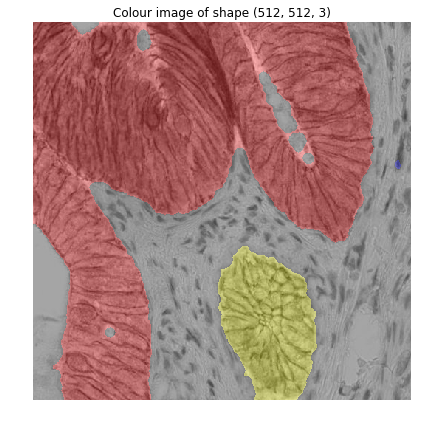

In [19]:
from skimage.measure import label
from skimage.morphology import binary_closing
from skimage.color import label2rgb

dab_image = hed_image[:, :, 2]

thresholded = dab_image > threshold_isodata(dab_image)

closed = binary_closing(thresholded, disk(7))

# label image regions
label_image = label(closed)

image_label_overlay = label2rgb(label_image, image=grayscale, bg_label=0)

plot_image(image_label_overlay)

Region #1
Pixel area: 138855
Perimeter: 2810.4591616530442
Shape eccentricity: 0.6776275090219733
Shape solidity: 0.7096120606373924

Region #3
Pixel area: 20211
Perimeter: 615.5706345359769
Shape eccentricity: 0.8135666120084726
Shape solidity: 0.9468284456104188



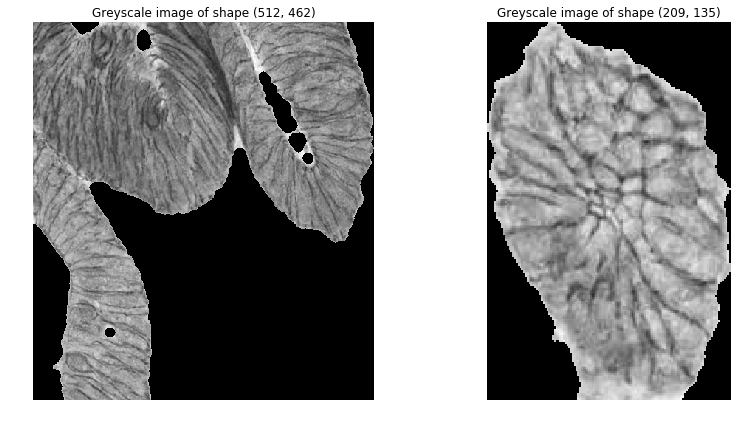

In [20]:
from skimage.measure import label, regionprops

regions = regionprops(label_image, intensity_image=grayscale)
regions = [region for region in regions if region.area > 200]

for region in regions:
    print(
        "Region #{}\nPixel area: {}\nPerimeter: {}\n"
        "Shape eccentricity: {}\nShape solidity: {}\n".format(
            region.label, region.filled_area, region.perimeter,
            region.eccentricity, region.solidity))

plot_image([region.intensity_image for region in regions])